## **OHW20 project: OOI profile sections**
### Visualizing an invisible boundary: locating the shelfbreak front in the northern Mid-Atlantic Bight

Contents

[Project description](#Project-description)

[Notebook setup](#Notebook-setup)

[Load data](#Load-Data)

[Time series scatter plots](#Plot-scatter-time-series)

[Extract downcast](#Extract-downcast)

[Extract down/upcast or both](#Extract-down/upcast-or-both)

[Vertical discretization of individual profiles](#Below-functions-perform-vertical-discretization-of-individual-profiles)

[Indicies to split individual profiles](#Indices-to-split-individual-profiles)

## Project descrtiption

The U.S. Ocean Observatories Initiative (OOI) provides data from moorings deployed in the Pioneer Array on the edge of the Northeast U.S. Shelf (NES) in the northern Mid-Atlantic Bight. Profiler moorings support wire-following profiling packages with a multidisciplinary sensor suite including temperature, conductivity (salinity), pressure (depth) and more. Profilers continuously sample these parameters over a specifie depth interval (20 meters below sea surface to 20 meter above the bottom). Although it may be straightforward to acquire and plot data from a single profile, or a single profiler over time, it is much more challenging to be able to visualize and analyze data from multiple profiler moorings. The goal of this project will be to develop flexible, scalable tools to assemble, plot, and analyze data from multiple moorings over time.

We are targeting a specific use case: locating the shelfbreak front and illustrating the dynamic movement of this invisible boundary. We would like to develop a flexible, scalable workflow implemented in a Jupyter Notebook to visualize and analyze CTD data (in particular, salinity and depth) from multiple profiler moorings. This use case will serve ocean scientists and students including those involved with NES-LTER.

For more information on the Pioneer Array please see (https://oceanobservatories.org/array/coastal-pioneer-array/)

## Notebook setup

In [2]:
# Note these libraries are used by Sage's notebook Profile_Examples_for_WHOI.ipynb
import requests
import os
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

# libraries importate by Filipe in gist.ipynb
import ctd
import gsw
from ctd.read import _basename

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})

[Back to top](#OHW20-project:-OOI-profile-sections)

## Load Data
The [OOI Data Portal](https://ooinet.oceanobservatories.org/) can be used to access data from any OOI instrument. The data typically come in NetCDF format. To create a custom data catalog, you need to sign up for a free account. Data for this project has already been requested by Stace through the portal and is available on the Wiki page of the project repository.

October 2019 recovered

- Inshore water depth of 92 m
- Central inshore water depth of 126 m
- Central offshore water depth of 146 m
- Offshore water depth of 451 m
- Distance between inshore and central inshore 15.32 km, between central inshore and central offshore 14.47 km, between central offshore and offshore 17.91 km (link to cruise report)


In [3]:
# Provide URL to load a single file that has already been downloaded to OOI's OPENDAP server
# remember to use #fillmismatch
# Create directory that includes all urls
data_url = {}
data_url['inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132326640Z-CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191006T150003-20191031T212239.977728.nc#fillmismatch'
data_url['central_inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132900316Z-CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191007T210003-20191031T212442.986087.nc#fillmismatch'
data_url['central_offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133142674Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191008T140003-20191031T212529.983845.nc#fillmismatch'
data_url['offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133343088Z-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0012_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191013T160003-20191031T211622.990750.nc#fillmismatch'


In [4]:
# Load the data file using xarray
def load2xarray(location):
    """
    Load data at given location and reduce to variables of interest.
    """
    ds = xr.open_dataset(data_url[location])
    ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
    print('Dataset '+ location +' has %d points' % ds.time.size)
    ds = ds[['ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','practical_salinity']]
    return ds

ds={}
for loc in list(data_url.keys()):
    ds[loc] = load2xarray(loc)

Dataset inshore has 158237 points
Dataset central_inshore has 210513 points
Dataset central_offshore has 236989 points
Dataset offshore has 199587 points


[Back to top](#OHW20-project:-OOI-profile-sections)

## Plot scatter time series

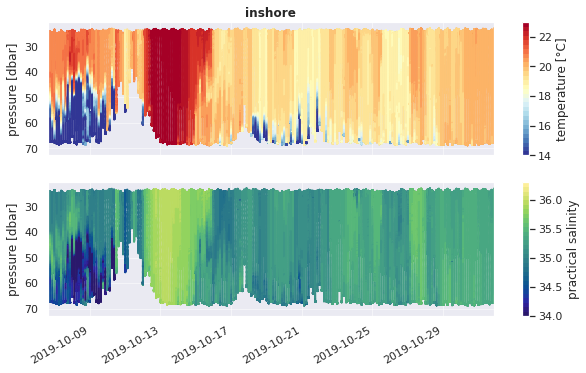

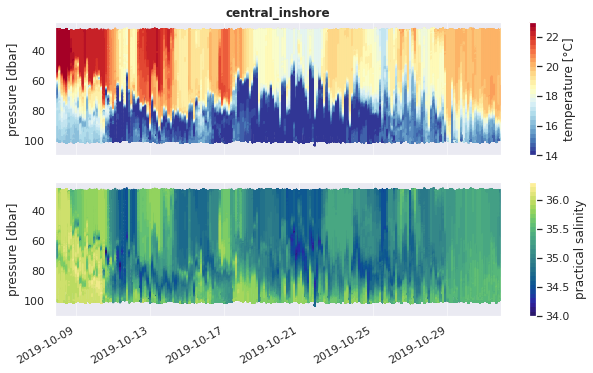

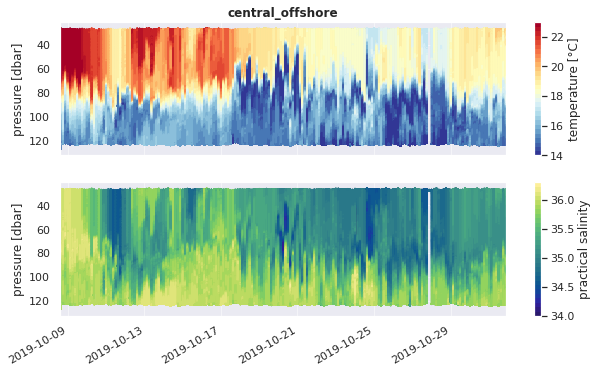

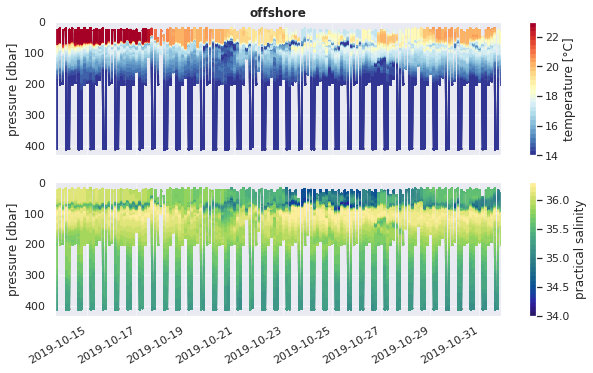

In [5]:
#####################################
# plotting function

def scatter_timeseries(ds,location=None):
    fig,ax = plt.subplots(figsize=(10,6),nrows=2,sharex=True,constrained_layout=False)
    cc = ax[0].scatter(ds.time,ds.ctdpf_ckl_seawater_pressure,s=1,
                    c=ds.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
    plt.colorbar(cc,ax=ax[0],label='temperature [\N{DEGREE SIGN}C]')
#     plt.xticks(rotation=30)
    ax[0].set_xlim(ds.time[0],ds.time[-1]) # Set the time limits to match the dataset


    cc = ax[1].scatter(ds.time,ds.ctdpf_ckl_seawater_pressure,s=1,
                    c=ds.practical_salinity,
                    cmap = plt.get_cmap('cmo.haline',30),vmin=34,vmax=36.3)
    plt.colorbar(cc,ax=ax[1],label='practical salinity')
#     plt.xticks(rotation=30)

    for axh in ax.flat: axh.set_ylabel('pressure [dbar]'); axh.invert_yaxis();
    if location: ax[0].set_title(location,fontweight='bold')
    fig.autofmt_xdate()

    return fig,ax

#######################################
# plot scatter timeseries for all locations
for loc in list(data_url.keys()):
    scatter_timeseries(ds[loc],loc)

## Select the same day for each profiler and plot

**This allows us to compare the timing of profilers**  
**I would prefer to do this as a function, rather than copy & paste, similar to cell above**  
SR: No need for function here I think

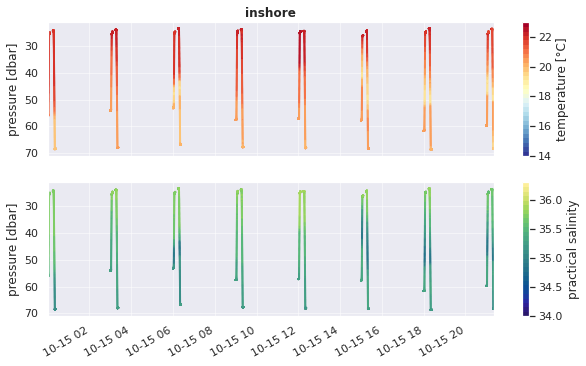

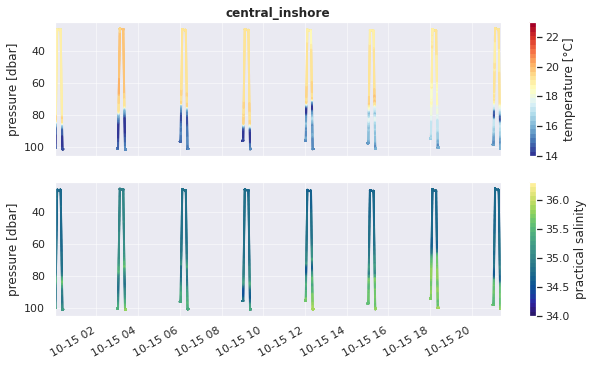

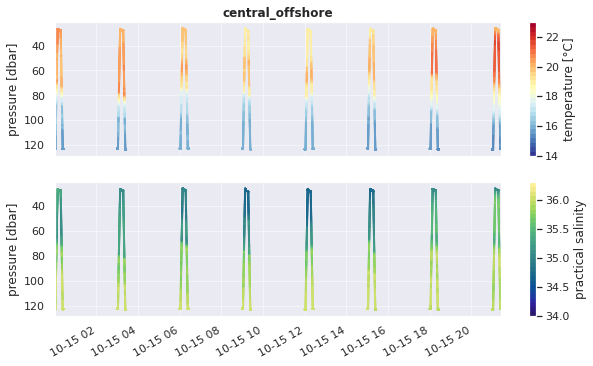

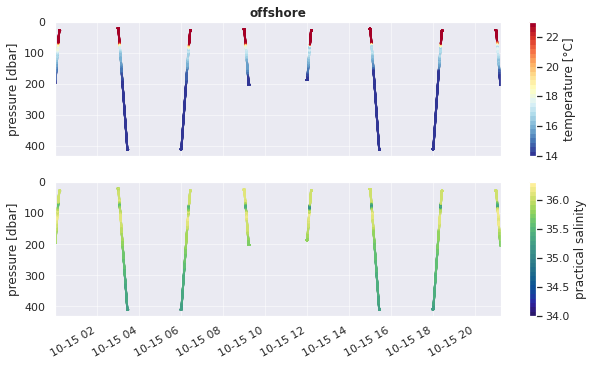

In [6]:
# select the same day from each location
D = "2019-10-15"
    
# plot scatter timeseries for all locations - one day
for loc in list(data_url.keys()):
    scatter_timeseries(ds[loc].sel(time=D),loc)

**SR: Seems like offshore is a bit more tricky and chosing either downcast or upcast only will not give best result**

[Back to top](#OHW20-project:-OOI-profile-sections)

## Separate down and up cast
### Test separation

In order to be able to plot a section we need individual profiles at each location at a given time. We cannot just resample by time because it is profiling data, which is not binned in vertical.  
A few steps I would take next:   
- extract the downcast only
- assign one time to each profile

**Trying to split casts based on changes in pressure**

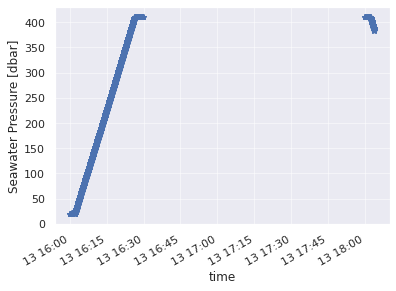

In [14]:
# plot first few profiles from initial dataset

dummy = ds['offshore']
dummy.ctdpf_ckl_seawater_pressure[0:2000].plot(marker='*',linestyle='')

We can see that there is always a downcast, followed by a time gap, then upcast and next downcast.

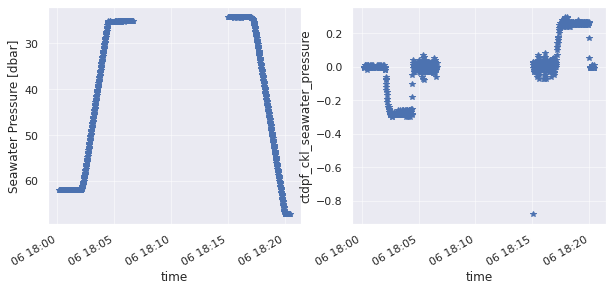

In [9]:
# plot first cast to check
fig,ax = plt.subplots(ncols=2,figsize=(10,4))
dummy.ctdpf_ckl_seawater_pressure[500:1200].plot(marker='*',linestyle='',ax=ax[0])
ax[0].invert_yaxis()
# plot difference in pressure
dummy.ctdpf_ckl_seawater_pressure[500:1200].diff(dim='time').plot(marker='*',linestyle='',ax=ax[1])

Based on these plots I can apply a thresshold of 0.1 for diff(pressure). Tried 0.2 but then lose too much data.

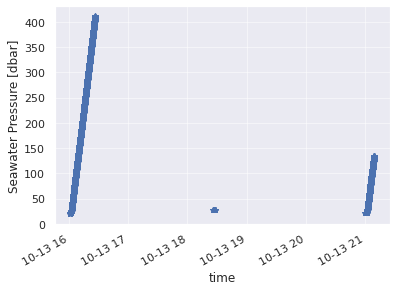

In [15]:
# select only data where pressure is increasing
dummy_down = dummy.where(dummy.ctdpf_ckl_seawater_pressure.diff(dim='time')>0.1)

# plot to check if it worked
dummy_down.ctdpf_ckl_seawater_pressure[0:4000].plot(marker='*',linestyle='')

Seems to work sort of ok?

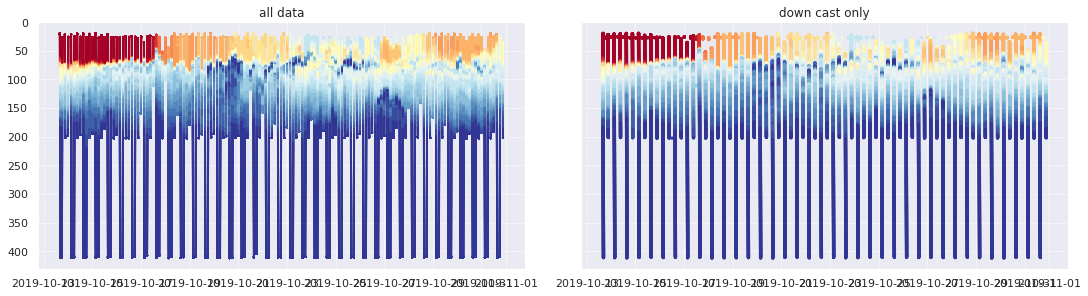

In [17]:
# plt scatter of old vs. new to check differences
fig,ax = plt.subplots(ncols=2,figsize=(15,4),sharey=True,constrained_layout=True)
ax[0].scatter(dummy.time,dummy.ctdpf_ckl_seawater_pressure,s=1,
                    c=dummy.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
ax[0].set_title('all data')
# ax[0].invert_yaxis()

ax[1].scatter(dummy_down.time,dummy_down.ctdpf_ckl_seawater_pressure,s=5,
                    c=dummy_down.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
ax[1].set_title('down cast only')
ax[1].invert_yaxis()


[Back to top](#OHW20-project:-OOI-profile-sections)

### Automate splitting

After test above we automate separation and perform for each profiler

In [19]:
def get_cast(ctd:xr, cast:str = 'down'):
    """
    Extract downcast, upcast or both and assign a specific profile attribute based on the cast
    """
    
    if cast == 'up':
        # select only data where pressure is decreasing
        down = ctd.where((np.diff(ctd.ctdpf_ckl_seawater_pressure) < 0.1) &
                         (np.fabs(ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time')) > .1)).dropna(dim = 'time')
        # out = down.assign(ctdpf_ckl_cast=xr.ones_like(down['ctdpf_ckl_seawater_pressure']) * 1)
        out = down.assign(ctdpf_ckl_cast='upcast')
        return out
    
    if cast == 'down':        
        # select only data where pressure is increasing
        down = ctd.where(ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time') > 0.1).dropna(dim = 'time')
        # out = down.assign(ctdpf_ckl_cast=xr.ones_like(down['ctdpf_ckl_seawater_pressure']) * 2)
        out = down.assign(ctdpf_ckl_cast='downcast')
        return out
    
    if cast == 'full':
        down = ctd.where(((np.diff(ctd.ctdpf_ckl_seawater_pressure) < 0.1) &
                         (np.fabs(ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time')) > .1)) | 
                         (ctd.ctdpf_ckl_seawater_pressure.diff(dim = 'time') > 0.1)).dropna(dim = 'time')
        idx = np.where(np.diff(xr.concat([down.ctdpf_ckl_seawater_pressure[0], 
                                          down.ctdpf_ckl_seawater_pressure], dim='time')) > 0.1, 'downcast', 'upcast')
        out = down.assign(ctdpf_ckl_cast=xr.DataArray(idx, dims=["time"]))
        return out
    
    if cast not in ('up', 'down', 'full'):
        raise NameError(
            f'Expected cast name to be `up`, `down`, or `full`, instead got {cast}'
        )

### Function to plot the timeseries

In [20]:
def plot_cast(sds:xr, label:str, ax, c=None, cmap=None) -> None:
    
    if 'temp' in label:
        c = sds.ctdpf_ckl_seawater_temperature
        cmap = plt.get_cmap('cmo.thermal',30)
    
    if 'sal' in label:
        c = sds.practical_salinity
        cmap = plt.get_cmap('cmo.haline',30) 
        
    vmin, vmax = c.min(), c.max()
    s = ax.scatter(sds.time,
                   sds.ctdpf_ckl_seawater_pressure,
                   s=1, c=c, cmap=cmap, vmin=vmin, vmax=vmax)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(s, cax=cax, label=label)
    
    for tlab in ax.get_xticklabels():
        tlab.set_rotation(40)
        tlab.set_horizontalalignment('right')

### Example with downcast

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 20.5 µs


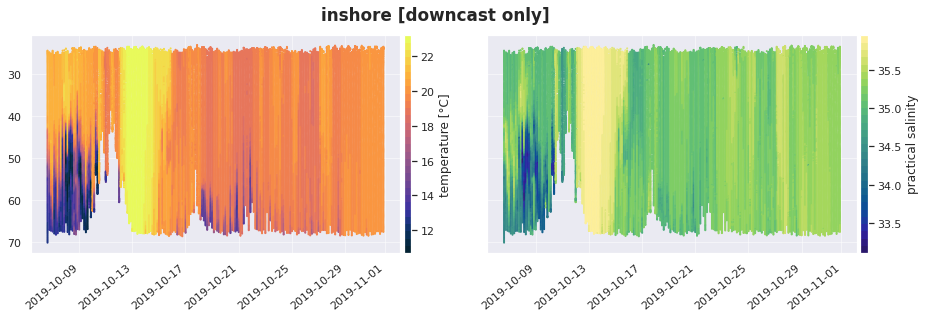

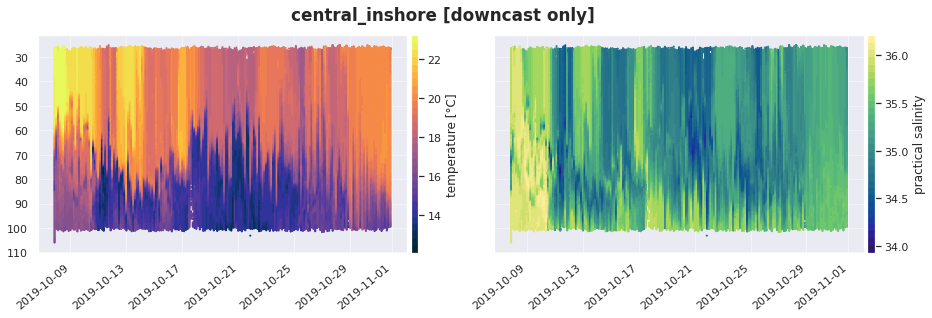

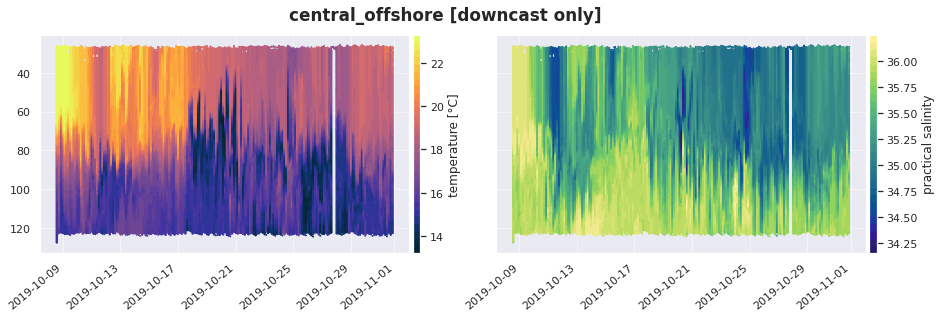

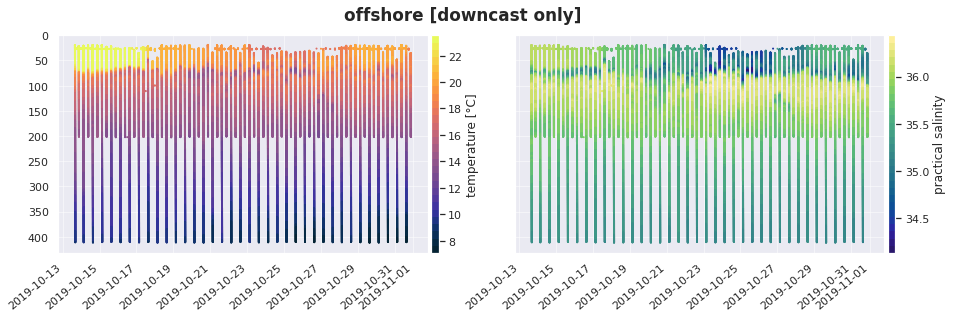

In [25]:
%time
downcast={}
cast = 'down'
for loc in list(data_url.keys())[:4]:
    downcast[loc] = get_cast(ds[loc], cast=cast)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,4), sharey=True, constrained_layout=True)
    plot_cast(sds=downcast[loc], 
              label='temperature [\N{DEGREE SIGN}C]', ax=ax[0])
    plot_cast(sds=downcast[loc], 
              label='practical salinity', ax=ax[1])
    
    ax[1].invert_yaxis()
    fig.suptitle(f"{loc} [{cast}cast only]", fontweight='bold')
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)

### Example with upcast

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 22.2 µs


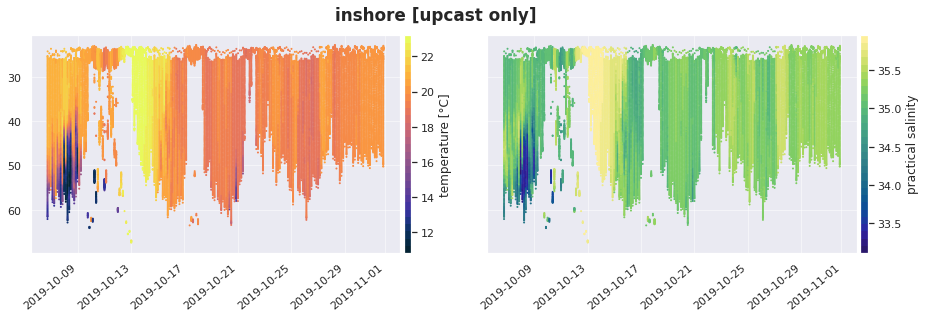

In [26]:
%time
upcast={}
cast = 'up'
for loc in list(data_url.keys())[:1]:
    upcast[loc] = get_cast(ds[loc], cast=cast)
       
    # plt scatter of old vs. new
    fig, ax = plt.subplots(ncols=2,figsize=(15,4), sharey=True, constrained_layout=True)
    plot_cast(sds=upcast[loc], 
              label='temperature [\N{DEGREE SIGN}C]', ax=ax[0])
    plot_cast(sds=upcast[loc], 
              label='practical salinity', ax=ax[1])
    
    ax[1].invert_yaxis()
    fig.suptitle(f"{loc} [{cast}cast only]", fontweight='bold')
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)

### Example with fullcast with intermittent values removed

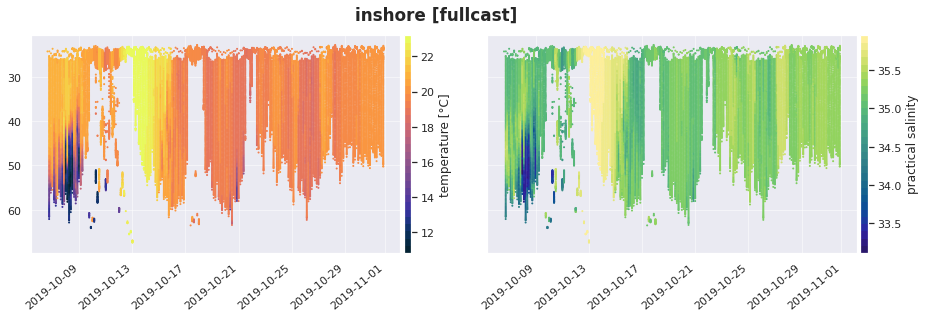

In [27]:
fullcast={}
cast = 'full'
for loc in list(data_url.keys())[:1]:
    fullcast[loc] = get_cast(ds[loc], cast=cast)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,4), sharey=True, constrained_layout=True)
    
    # display one of the casts just for comparison with previous
    sds = fullcast[loc].where(fullcast[loc].ctdpf_ckl_cast == 'upcast')
    plot_cast(sds=sds, 
              label='temperature [\N{DEGREE SIGN}C]', ax=ax[0])
    plot_cast(sds=sds, 
              label='practical salinity', ax=ax[1])
    
    ax[1].invert_yaxis()
    fig.suptitle(f"{loc} [{cast}cast]", fontweight='bold')
    fig.autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)

[Back to top](#OHW20-project:-OOI-profile-sections)

## Vertical binning of individual profiles

### Filter and binning functions

In [69]:
def profile_filt(data: dict, key: str, window_length: int, polyorder: int, profile_disp: bool) -> dict:
    """
    Profile smoothing using `savgol_filter`. In general `savgol_filter` produces good results compared to other 
    methods I have tried. For more, please check https://docs.scipy.org/doc/scipy/reference/signal.html
    """
    from scipy.signal import savgol_filter
    
    out = data
    out[key] = savgol_filter(data[key], window_length=window_length, polyorder=polyorder)
    
    if profile_disp is True:
        fig, ax = plt.subplots()
        ax.plot(out[key], data['pres'], '-r', label='savgol_filter')
        ax.plot(data[key], data['pres'], '-k', label='original')
        ax.invert_yaxis()
        plt.show()
    return out
                
    
def profile_interp(pres: np.array, y: np.array, key: str, start: float = 20., end: float = 100., 
                   step: float = 1., method: str = 'binning', filt_profile: bool = False, 
                   window_length: int = 5, polyorder: int = 1, profile_disp: bool = False) -> dict:
    """
    Interpolate CTD profiles into a constant sampling rate. 
    Optionally, smooth the profile. Often needed in the case of fluorescence profiles
    :param: pres - pressure or any other x-like var
    :param: y - temperature, salinity, etc.
    :param: start - start position of vertical discretization (pressure). default .5
    :param: end - end position of the vertical discretization (pressure). default 100
    :param: step - discretization step. default 1
    :param: method - discretization method (binning or interpolation). default binning
    :param: filt_profile - whether to filter the profile or not (True-filter). default False
    :param: window_length - if filt_profile is set to True: the length of the filter window 
                            (i.e., the number of coefficients). default 5
    :param: polyorder - order of the polynomial used to fit the samples. default 1
    :param: profile_disp - if filt_profile is set to True: displayed the original versus filtered profile
    """
        
    znew = np.arange(start, end + step, step)
    if window_length % 2 == 0:
        window_length -= 1
    
    sz = pres.size
    if sz % 2 == 0:
        sz -= 1
        
    # window size == 5 or else odd
    window_length = min(window_length, sz)  
    polyorder = min(polyorder, window_length)

    if 'bin' in method:
        interp_prof = []
        append = interp_prof.append
    
        # There is a 'groupby' command from xarray which is handy. 
        # But due to time constraint I went the traditional way. 
        for i, z in enumerate(znew[:-1]):
            upper = z + step / 2
            lower = z - step / 2
            if i == 0:
                lower = max(0, z - step / 2)
            idx = np.where((pres > lower) & (pres <= upper))[0]
            if idx.size == 0:
                append(np.nan)
                continue
            if y[idx].mean().values > 100:
                print(y[idx])
            append(y[idx].mean().values)
            
        out = {'pres': znew[:-1], key: np.array(interp_prof)}
        if filt_profile is True:
            return profile_filt(data=out, key=key,
                                window_length=window_length, 
                                polyorder=polyorder, 
                                profile_disp=profile_disp)
        return out
    
    if 'interp' in method:
        from scipy import interpolate
        
        # temperature, salinity, etc
        f = interpolate.interp1d(pres, y, fill_value=(np.nan, np.nan))
        out = {'pres': znew, key: f(znew)}
        if filt_profile is True:
            return profile_filt(data=out, key=key,
                                window_length=window_length, 
                                polyorder=polyorder, 
                                profile_disp=profile_disp)
        return out

[Back to top](#OHW20-project:-OOI-profile-sections)

## Create 2D array of profiles
### Split profiles

In [67]:
def split_profiles(pres: np.array) -> tuple:
    pos = np.where(np.diff(pres) < 0)[0]
    start_points = np.hstack((0, pos + 1))
    end_points = np.hstack((pos, pres.size))
    return start_points, end_points

# get start and end indices of each profile
start_idx, end_idx = split_profiles(pres=downcast['inshore'].ctdpf_ckl_seawater_pressure)
start_idx, end_idx, start_idx.size, end_idx.size

(array([    0,   180,   348, ..., 42342, 42343, 42346]),
 array([  179,   347,   514, ..., 42342, 42345, 42539]),
 2422,
 2422)

#### Test: Vis Split Profile

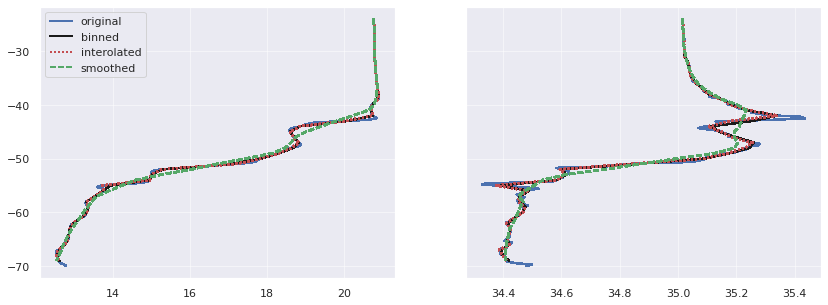

In [68]:
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharey='all')
z = downcast['inshore'].ctdpf_ckl_seawater_pressure[start_idx[0]:end_idx[0]]
t = downcast['inshore'].ctdpf_ckl_seawater_temperature[start_idx[0]:end_idx[0]]
s = downcast['inshore'].practical_salinity[start_idx[0]:end_idx[0]]
ax[0].plot(t, -z, label='original')
ax[1].plot(s, -z)

# Interp/bin profile
keys = 'temp', 'sal'
for i, y in enumerate((t, s)):
    # discretization by grouping    
    out = profile_interp(pres=z, y=y, key=keys[i], start=np.floor(z.min()), 
                         end=np.ceil(z.max()), step=1, method='binning')
    ax[i].plot(out[keys[i]], -out['pres'], '-k', label='binned')

    # discretization by interpolation
    out = profile_interp(pres=z, y=y, key=keys[i], start=np.ceil(z.min()), 
                     end=np.floor(z.max()), step=1, method='interpolate')
    ax[i].plot(out[keys[i]], -out['pres'], ':r', label='interolated')
    
    # discretization and smoothing
    out = profile_interp(pres=z, y=y, key=keys[i], start=np.floor(z.min()), 
                         end=np.ceil(z.max()), step=1, method='binning', filt_profile=True)
    ax[i].plot(out[keys[i]], -out['pres'], '--g', label='smoothed')

ax[0].legend()

### Sorting profs into 2D arrays with equal depth range

In [111]:
def grid_data(ds,loc):
    """
        Put individual profiles into 2D array
        :param: dataset, i.e. either ds, upcast or fullcast
        :param: which location to use
        
        :output: sal,temp,dates(datetime),pres(pressure)
    """
    sal = []
    temp = []
    pres = []
#     dates = []
    dates2 = []
    append_s = sal.append
    append_t = temp.append
#     append_d = dates.append
    append_datetime = dates2.append
    
    # get start and end indices of each profile
    start_idx, end_idx = split_profiles(pres=ds[loc].ctdpf_ckl_seawater_pressure)

    for i, (sidx, eidx) in enumerate(zip(start_idx, end_idx)):
        s = ds[loc].practical_salinity[sidx:eidx+1]
        t = ds[loc].ctdpf_ckl_seawater_temperature[sidx:eidx+1]
        z = ds[loc].ctdpf_ckl_seawater_pressure[sidx:eidx+1]

        p = (100 * i + 1) / start_idx.size
        if z.size < 10:
#             if p % 5 < 0.1:
#                 print(f'Start: {sidx:>6} | End: {eidx:>6} | ArrayLen: {t.size:>4} | Skip | {p:.2f}%')
            continue
#         if p % 5 < 0.1:
#             print(f'Start: {sidx:>6} | End: {eidx:>6} | ArrayLen: {t.size:>4} | {p:.2f}%')
        append_d(ds[loc].coords['time'][sidx:eidx+1].astype('float').values.mean())
        append_datetime(ds[loc].coords['time'][sidx:eidx+1].mean().values)

        # Interp/bin profile
        # discretization by grouping    
        out_s = profile_interp(pres=z, y=s, key='sal',end=450)
        append_s(out_s['sal'])
        if sidx == 0:
            pres = out_s['pres']
        out_t = profile_interp(pres=z, y=t, key='temp',end=450)# deepest profiler at ~450m
        append_t(out_t['temp'])


    sal = np.array(sal).T
    temp = np.array(temp).T
#     dates = np.repeat(np.array(dates).reshape(1, -1), sal.shape[0], axis=0)
    pres = np.repeat(np.array(pres).reshape(-1, 1), sal.shape[1], axis=1)
#     print(sal, sal.shape, temp.shape, dates.shape, pres.shape);
    return sal,temp,dates2,pres

In [88]:
# test function
sal,temp,dates,pres = grid_data(downcast,'inshore')

Start:      0 | End:    179 | ArrayLen:  180 | 0.00%
Start:    180 | End:    347 | ArrayLen:  168 | 0.04%
Start:    348 | End:    514 | ArrayLen:  167 | 0.08%
Start:   4194 | End:   4196 | ArrayLen:    3 | Skip | 5.04%
Start:   4197 | End:   4200 | ArrayLen:    4 | Skip | 5.08%
Start:   5245 | End:   5245 | ArrayLen:    1 | Skip | 10.03%
Start:   5246 | End:   5248 | ArrayLen:    3 | Skip | 10.07%
Start:   6328 | End:   6332 | ArrayLen:    5 | Skip | 15.03%
Start:   6333 | End:   6335 | ArrayLen:    3 | Skip | 15.07%
Start:   7066 | End:   7069 | ArrayLen:    4 | Skip | 20.03%
Start:   7070 | End:   7073 | ArrayLen:    4 | Skip | 20.07%
Start:   7787 | End:   7790 | ArrayLen:    4 | Skip | 25.02%
Start:   7791 | End:   7792 | ArrayLen:    2 | Skip | 25.06%
Start:   8592 | End:   8596 | ArrayLen:    5 | Skip | 30.02%
Start:   8597 | End:   8599 | ArrayLen:    3 | Skip | 30.06%
Start:   8600 | End:   8602 | ArrayLen:    3 | Skip | 30.10%
Start:   9188 | End:   9193 | ArrayLen:    6 | Ski

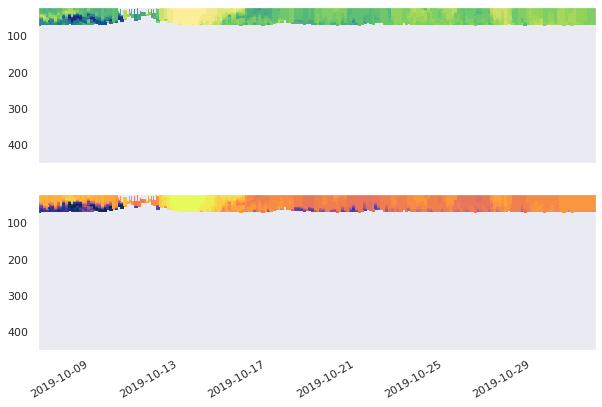

In [75]:
# plot gridded fields
fig, ax = plt.subplots(2,1, figsize=(10, 7), sharex='all')
ax[0].pcolormesh(dates, pres, sal,
                 cmap = plt.get_cmap('cmo.haline',30))
ax[0].set_ylim(pres.min(), pres.max())
ax[0].invert_yaxis()
ax[1].pcolormesh(dates, pres, temp, 
                 cmap=plt.get_cmap('cmo.thermal',30))
ax[1].set_ylim(pres.min(), pres.max())
ax[1].invert_yaxis()
fig.autofmt_xdate()

### Write xarray

In [ ]:
def write_xarray(loc):
    sal,temp,dates,pres = grid_data(downcast,loc)
    ds_xr = xr.DataArray(temp, dims=("pressure", "time"), 
                         coords={"time": dates, "pressure" :pres[:,0]}).to_dataset(name='temp')
    ds_xr['sal'] = (('pressure','time'),sal) 
    return ds_xr

xr_inshore = write_xarray('inshore')
xr_central_inshore = write_xarray('central_inshore')
xr_central_offshore = write_xarray('central_offshore')
# xr_offshore = write_xarray('offshore')

**SR:Somehow grid_data produced an empty pressure variable for the offshore profiler - not sure yet why. For now I am using the pressure from one of the other profilers, which is the same since we binned every profile onto the same vertical grid.** 

In [ ]:
# do offshore manually
sal,temp,dates,pres = grid_data(downcast,'offshore')
xr_offshore = xr.DataArray(temp, dims=("time", "pressure"), coords={"time": dates, "pressure" :xr_inshore.pressure}).to_dataset(name='temp')
xr_offshore['sal'] = (('pressure','time'),sal)

In [148]:
# check sampling frequency
print('Offshore: ', str(offshore_xr.time[1:5].values))
print('\n Inshore: ', str(xr_inshore.time[1:5].values))
print('\n Central Inshore: ', str(xr_central_inshore.time[1:5].values))
print('\n Central Offshore: ', str(xr_central_offshore.time[1:5].values))


Offshore:  ['2019-10-13T21:07:50.474331550' '2019-10-14T03:14:28.286278123'
 '2019-10-14T09:08:21.424580712' '2019-10-14T15:14:48.957964920']

 Inshore:  ['2019-10-06T18:18:34.462174942' '2019-10-06T21:18:35.959563224'
 '2019-10-07T00:18:39.472222225' '2019-10-07T03:18:45.469387756']

 Central Inshore:  ['2019-10-08T00:19:41.820635758' '2019-10-08T03:19:38.253447828'
 '2019-10-08T06:19:33.230658789' '2019-10-08T09:19:30.004432553']

 Central Offshore:  ['2019-10-08T15:19:59.910149749' '2019-10-08T18:20:01.954773870'
 '2019-10-08T21:19:59.841956472' '2019-10-09T00:20:02.908196720']


Both inshore moorings and central offshore seem to sample at roughly 3hr interval, while central offshore is at 6hrs roughly

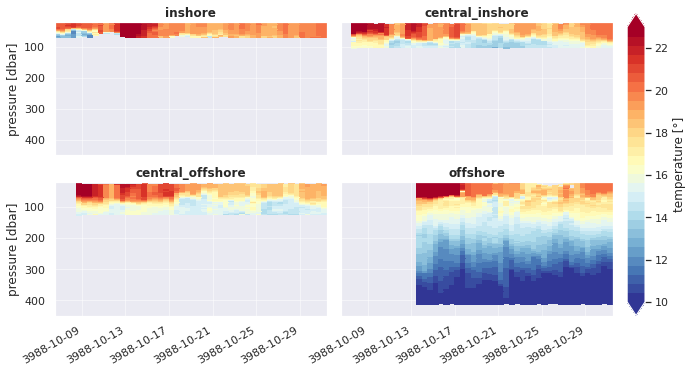

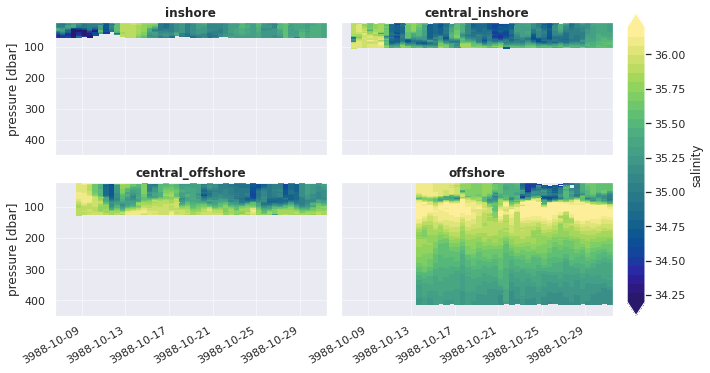

In [308]:
# Resample and concatenate all profiler datasets

# interval for resampling
dt = '12H'

# concatenate all xarrays
ooi_profiles = xr.concat([xr_inshore.resample(time=dt).mean(),
                         xr_central_inshore.resample(time=dt).mean(),
                         xr_central_offshore.resample(time=dt).mean(),
                         offshore_xr.resample(time=dt).mean()],"lat")

# add latitude values for each profiler
ooi_profiles = ooi_profiles.assign_coords(lat=[downcast['inshore'].lat[0].values,
                               downcast['central_inshore'].lat[0].values,
                               downcast['central_offshore'].lat[0].values,
                               downcast['offshore'].lat[0].values]).transpose("time", "pressure", "lat")

ooi_profiles['names'] = ['inshore','central_inshore','central_offshore','offshore']

# save to netcdf
ooi_profiles.to_netcdf('ooi_profiles_2D_downcast_'+ dt +'.nc')

# temperature
fig,ax = plt.subplots(figsize=(10,6),ncols=2,nrows=2,sharex=True,
                      sharey=True)
for ax,i in zip(ax.flat,range(4)):
    cc=ax.pcolormesh(ooi_profiles.time,ooi_profiles.pressure,
                     ooi_profiles['temp'][:,:,i].T,vmin=10,vmax=23,
                    cmap=plt.get_cmap('RdYlBu_r',30))
    ax.set_title(ooi_profiles['names'][i].values,fontweight='bold')
    ax.grid()
    if (i==0) or (i==2): ax.set_ylabel('pressure [dbar]')
ax.invert_yaxis()
fig.autofmt_xdate()

fig.subplots_adjust(right=0.9,wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.2, 0.025, 0.7])
cb = fig.colorbar(cc,cax=cbar_ax,extend='both',label='temperature [\N{DEGREE SIGN}]')

# salinity
fig,ax = plt.subplots(figsize=(10,6),ncols=2,nrows=2,sharex=True,
                      sharey=True)
for ax,i in zip(ax.flat,range(4)):
    cc=ax.pcolormesh(ooi_profiles.time,ooi_profiles.pressure,
                     ooi_profiles['sal'][:,:,i].T,vmin=34.2,vmax=36.2,
                    cmap=plt.get_cmap('cmo.haline',30))
    ax.set_title(ooi_profiles['names'][i].values,fontweight='bold')
    ax.grid()
    if (i==0) or (i==2): ax.set_ylabel('pressure [dbar]')
ax.invert_yaxis()
fig.autofmt_xdate()

fig.subplots_adjust(right=0.9,wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.2, 0.025, 0.7])
cb = fig.colorbar(cc,cax=cbar_ax,extend='both',label='salinity')

Text(0.5, 0.98, '2019-10-17T12:00:00.000000000')

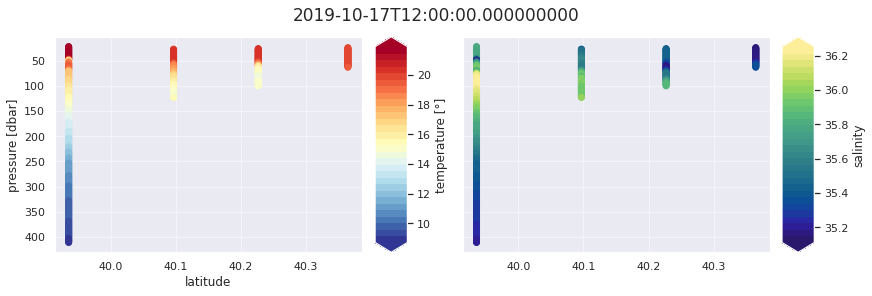

In [307]:
# plot section
date = '2019-10-17T12:00:00'

xm,ym = np.meshgrid(ooi_profiles.lat,ooi_profiles.pressure)

fig,(ax,ax1) = plt.subplots(ncols=2,figsize=(12,4),sharey=True,constrained_layout=True)
cc = ax.scatter(xm,ym,c=ooi_profiles['temp'].sel(time=date,method='nearest'),
               cmap=plt.get_cmap('RdYlBu_r',30))
ax.invert_yaxis()
cb = plt.colorbar(cc,label='temperature [\N{Degree Sign}]',ax=ax,extend='both')
ax.set_ylabel('pressure [dbar]')
ax.set_xlabel('latitude')

cc = ax1.scatter(xm,ym,c=ooi_profiles['sal'].sel(time=date,method='nearest'),
                cmap=plt.get_cmap('cmo.haline',30))
cb = plt.colorbar(cc,label='salinity',ax=ax1,extend='both')
ax.set_xlabel('latitude')

fig.suptitle(ooi_profiles['time'].sel(time=date,method='nearest').values)


[Back to top](#OHW20-project:-OOI-profile-sections)